In [1]:
import os
os.chdir("../..")

In [2]:
import torch
from utils.dataset_loader import *
from utils.model_utils import *
from utils.train_utils import *
from utils.metrics import *
from utils.visualization import *

C:\Users\Yash\Documents\Development\Projects\final_year\env\Lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.22). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

[INFO] Using device: cuda


In [4]:
data_dir = "wildfire_dataset_scaled"
batch_size = 32
num_epochs = 15  # Increased for augmented data
learning_rate = 0.001
num_classes = 2
model_name = "resnet18"
output_dir = "outputs/models/augmented"
os.makedirs(output_dir, exist_ok=True)


In [5]:
print("[INFO] Loading augmented datasets...")
train_loader, val_loader, test_loader = load_datasets(
    data_dir=data_dir, batch_size=batch_size, augmentation="augmented"
)
print("[INFO] Augmented datasets loaded successfully!")

[INFO] Loading augmented datasets...
[INFO] Augmented datasets loaded successfully!


C:\Users\Yash\Documents\Development\Projects\final_year\env\Lib\site-packages\pydantic\main.py:214: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)


In [6]:
# Initialize the model
print(f"\n[INFO] Starting Training for Model: {model_name} with Augmented Data\n")
print(f"[INFO] Initializing {model_name} model...")
model = initialize_model(
    model_name=model_name,
    num_classes=num_classes,
    pretrained=True,
    freeze_all=True  # Baseline augmentation: Freeze all layers
)
print("[INFO] Model initialized successfully!")


[INFO] Starting Training for Model: efficientnet_b0 with Augmented Data

[INFO] Initializing efficientnet_b0 model...
[INFO] Model initialized successfully!


In [7]:
# Define loss function and optimizer
print("[INFO] Setting up loss function and optimizer...")
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
print("[INFO] Loss function and optimizer set up!")

[INFO] Setting up loss function and optimizer...
[INFO] Loss function and optimizer set up!


In [8]:
# Train the model
print("[INFO] Starting model training with augmented data...")
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=None,  # No LR scheduler for augmented baseline
    device=device,
    save_path=os.path.join(output_dir, f"{model_name}_augmented.pt"),
    early_stop_patience=10,  # Early stopping patience
    monitor_metric="val_recall"
)
print("[INFO] Training completed successfully!")

[INFO] Starting model training with augmented data...

Starting training...



[INFO] Best model saved with val_recall: 0.8415
Epoch [1]: Train Loss: 0.6103, Train Acc: 0.6698 | Val Loss: 0.5317, Val Acc: 0.7214, Val Recall: 0.8415, Val F1: 0.7871


[INFO] Best model saved with val_recall: 0.8537
Epoch [2]: Train Loss: 0.5230, Train Acc: 0.7435 | Val Loss: 0.5072, Val Acc: 0.7488, Val Recall: 0.8537, Val F1: 0.8061


[INFO] Best model saved with val_recall: 0.9228
Epoch [3]: Train Loss: 0.5305, Train Acc: 0.7234 | Val Loss: 0.4621, Val Acc: 0.7811, Val Recall: 0.9228, Val F1: 0.8376


[INFO] No improvement in val_recall. Patience: 1/10
Epoch [4]: Train Loss: 0.5028, Train Acc: 0.7435 | Val Loss: 0.4734, Val Acc: 0.7761, Val Recall: 0.8537, Val F1: 0.8235


[INFO] No improvement in val_recall. Patience: 2/10
Epoch [5]: Train Loss: 0.4996, Train Acc: 0.7488 | Val Loss: 0.4391, Val Acc: 0.7910, Val Recall: 0.8577, Val F1: 0.8340


[INFO] No improvement in val_recall. Patience: 3/10
Epoch [6]: Train Loss: 0.4919, Train Acc: 0.7615 | Val Loss: 0.4612, Val Acc: 0.7662, Val Recall: 0.9024, Val F1: 0.8253


[INFO] No improvement in val_recall. Patience: 4/10
Epoch [7]: Train Loss: 0.4941, Train Acc: 0.7615 | Val Loss: 0.4778, Val Acc: 0.7711, Val Recall: 0.8374, Val F1: 0.8175


[INFO] No improvement in val_recall. Patience: 5/10
Epoch [8]: Train Loss: 0.4907, Train Acc: 0.7546 | Val Loss: 0.4389, Val Acc: 0.7985, Val Recall: 0.9228, Val F1: 0.8486


[INFO] No improvement in val_recall. Patience: 6/10
Epoch [9]: Train Loss: 0.4783, Train Acc: 0.7695 | Val Loss: 0.4671, Val Acc: 0.7985, Val Recall: 0.9106, Val F1: 0.8469


[INFO] No improvement in val_recall. Patience: 7/10
Epoch [10]: Train Loss: 0.4911, Train Acc: 0.7562 | Val Loss: 0.4301, Val Acc: 0.7662, Val Recall: 0.9065, Val F1: 0.8259


[INFO] No improvement in val_recall. Patience: 8/10
Epoch [11]: Train Loss: 0.4832, Train Acc: 0.7647 | Val Loss: 0.4314, Val Acc: 0.8010, Val Recall: 0.8496, Val F1: 0.8394


[INFO] No improvement in val_recall. Patience: 9/10
Epoch [12]: Train Loss: 0.4885, Train Acc: 0.7711 | Val Loss: 0.4209, Val Acc: 0.7985, Val Recall: 0.8618, Val F1: 0.8396


[INFO] No improvement in val_recall. Patience: 10/10
Epoch [13]: Train Loss: 0.4793, Train Acc: 0.7668 | Val Loss: 0.4245, Val Acc: 0.7910, Val Recall: 0.9106, Val F1: 0.8421
[INFO] Training stopped after 13 epochs. Best val_recall: 0.9228

[INFO] Training completed successfully!


In [9]:
# Evaluate the model
print("[INFO] Evaluating the model...")
metrics = evaluate_model(
    model=model,
    test_loader=test_loader,
    classes=["No Fire", "Fire"],
    device=device
)
print(f"\n[INFO] Metrics for {model_name} with Augmented Data:\n{metrics}")

[INFO] Evaluating the model...

[INFO] Metrics for efficientnet_b0 with Augmented Data:
{'classification_report': {'No Fire': {'precision': 0.7874015748031497, 'recall': 0.6289308176100629, 'f1-score': 0.6993006993006993, 'support': 159.0}, 'Fire': {'precision': 0.7915194346289752, 'recall': 0.8924302788844621, 'f1-score': 0.8389513108614233, 'support': 251.0}, 'accuracy': 0.7902439024390244, 'macro avg': {'precision': 0.7894605047160624, 'recall': 0.7606805482472625, 'f1-score': 0.7691260050810613, 'support': 410.0}, 'weighted avg': {'precision': 0.789922508501399, 'recall': 0.7902439024390244, 'f1-score': 0.7847941224756791, 'support': 410.0}}, 'confusion_matrix': array([[100,  59],
       [ 27, 224]]), 'roc_auc': np.float64(0.8738129244030169)}


[INFO] Saving training and evaluation results...
[INFO] Training plot saved to outputs/models/augmented\efficientnet_b0_augmented_training_curve.png
[INFO] Confusion matrix saved to outputs/models/augmented\efficientnet_b0_augmented_confusion_matrix.png


KeyError: 'y_true'

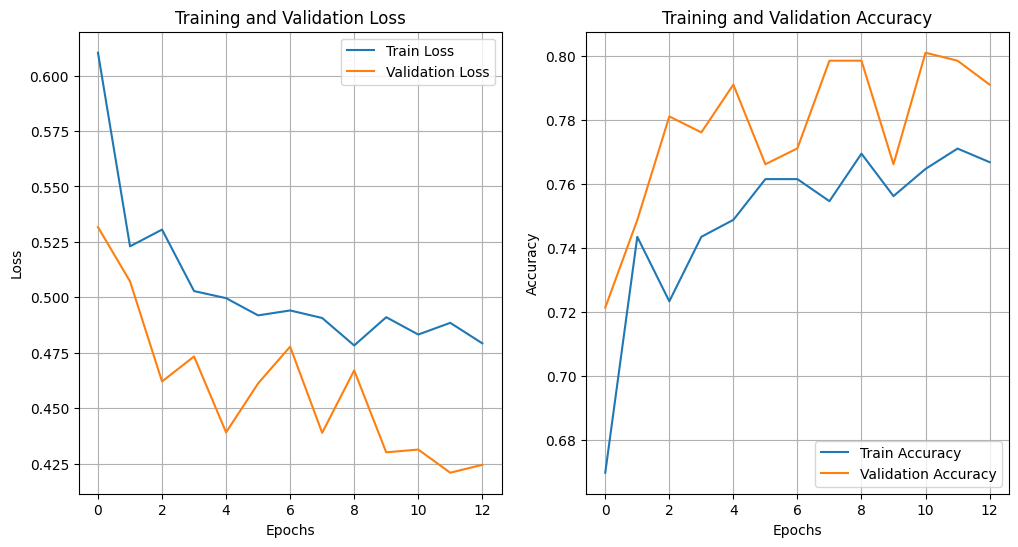

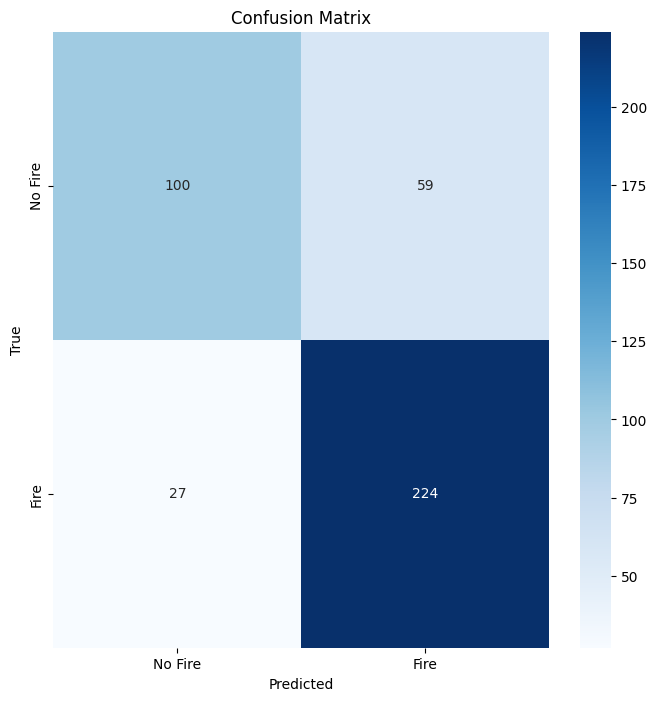

In [10]:
print("[INFO] Saving training and evaluation results...")

# Training curve
plot_training(
    history, output_path=os.path.join(output_dir, f"{model_name}_augmented_training_curve.png")
)

# Confusion matrix
plot_confusion_matrix(
    cm=metrics["confusion_matrix"],
    classes=["No Fire", "Fire"],
    output_path=os.path.join(output_dir, f"{model_name}_augmented_confusion_matrix.png")
)

# ROC Curve
plot_roc_curve(
    y_true=metrics["y_true"],
    y_scores=metrics["y_scores"],
    output_path=os.path.join(output_dir, f"{model_name}_augmented_roc_curve.png")
)

# Precision-Recall Curve
plot_precision_recall(
    y_true=metrics["y_true"],
    y_scores=metrics["y_scores"],
    output_path=os.path.join(output_dir, f"{model_name}_augmented_precision_recall.png")
)

print("[INFO] All results saved successfully!")